In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u

import emcee

from importlib import reload

import h5py

from scipy.interpolate import interp1d

import seaborn as sns

import rewtlisamples

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

This is just a function that draws from the LI prior for $M_\mathrm{min} \leq m_2 < m_1 < M_\mathrm{max}$ and $d_L < d_{L,\mathrm{max}}$.

In [3]:
class UniformPosterior(object):
    def __init__(self, mmin, mmax, dlmax):
        self.mmin = mmin
        self.mmax = mmax
        self.dlmax = dlmax
        
        self.zinterp = expm1(linspace(log(1), log(10+1), 1000))
        self.dlinterp = Planck15.luminosity_distance(self.zinterp).to(u.Mpc).value
        
    def __call__(self, m1m2dl):
        m1d, m2d, dl = m1m2dl
        
        if m2d > m1d:
            return np.NINF
        if m2d < self.mmin:
            return np.NINF
        if m1d > self.mmax:
            return np.NINF
        if dl > self.dlmax:
            return np.NINF
        if dl < 0:
            return np.NINF
        
        logprior = 2.0*log(dl)
        
        return logprior

We instantiate a posterior object, draw some initial conditions, and construct a sampler:

In [4]:
logpost = UniformPosterior(5, 100, 5000)

In [5]:
m1 = random.uniform(low=5, high=100, size=128)
m2 = random.uniform(low=5, high=100, size=128)

mh = np.where(m1 > m2, m1, m2)
ml = np.where(m1 > m2, m2, m1)

dl = random.uniform(low=0, high=5000, size=128)

pts = column_stack((mh, ml, dl))

In [6]:
sampler = emcee.EnsembleSampler(128, 3, logpost)

Now we run the sampler for 1024 steps (burnin), and then reset it.

In [7]:
samples, _, _ = sampler.run_mcmc(pts, 1024)

In [8]:
sampler.reset()

Now we run for 16384 samples (proper sampling).

In [9]:
sampler.run_mcmc(samples, 16384);

The samples look like they correspond to the prior (flat in detector frame, $d_L^2$).

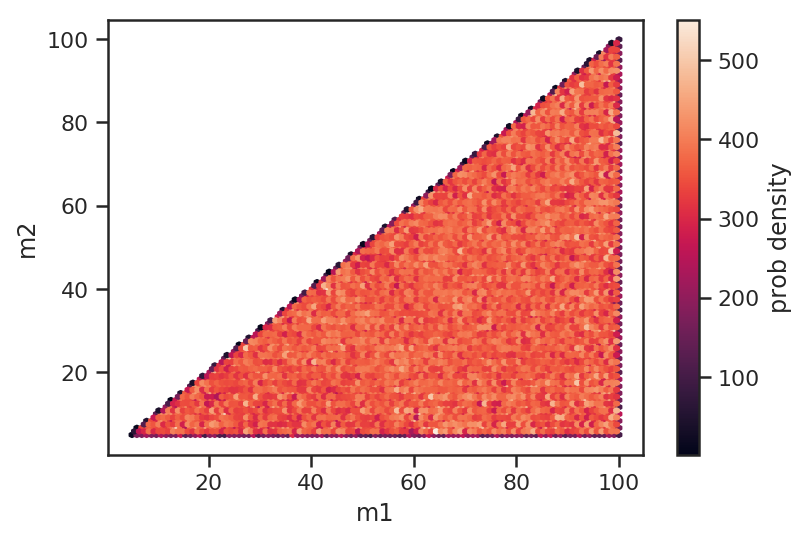

In [10]:
img = hexbin(sampler.chain[:,:,0].flatten(), sampler.chain[:,:,1].flatten(), mincnt=1)
cbar = plt.colorbar(img)
plt.xlabel("m1")
plt.ylabel("m2")
cbar.set_label("prob density")

In [11]:
sampler.chain.shape

(128, 16384, 3)

0.0020564285007205196


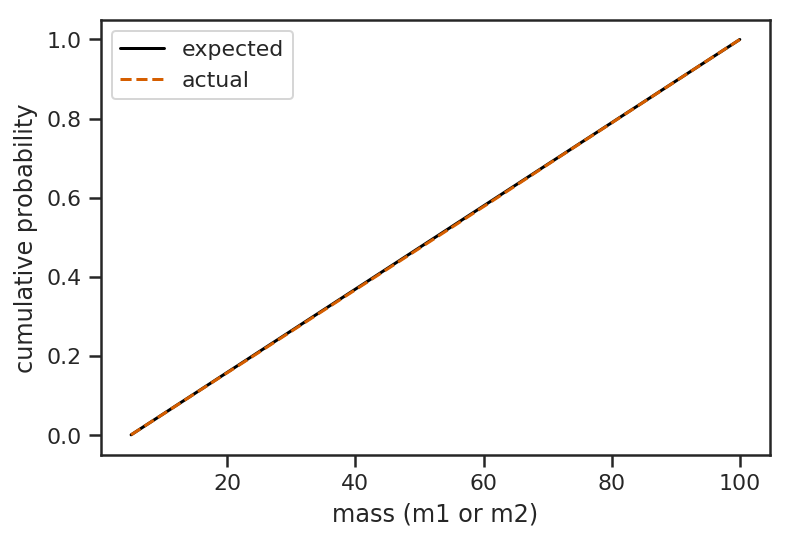

In [12]:
fig, ax = plt.subplots()

n_walkers, n_samples_per_walker, n_dim = sampler.chain.shape
n_samples = n_walkers*n_samples_per_walker

m_range = linspace(5.0, 100.0, 1000)

cdf = (m_range-5)/(100-5)
ax.plot(m_range, cdf, color="black", label="expected")

samples = concatenate((
    sampler.chain[:,:,0],
    sampler.chain[:,:,1],
)).flatten()

ecdf = numpy.asarray([
    numpy.count_nonzero(samples <= m) / (2*n_samples)
    for m in m_range
])
KS_test = np.max(np.abs(cdf - ecdf))
ax.plot(m_range, ecdf, linestyle="--", color="C3", label="actual")

ax.set_xlabel("mass (m1 or m2)")
ax.set_ylabel("cumulative probability")

ax.legend()

print(KS_test)

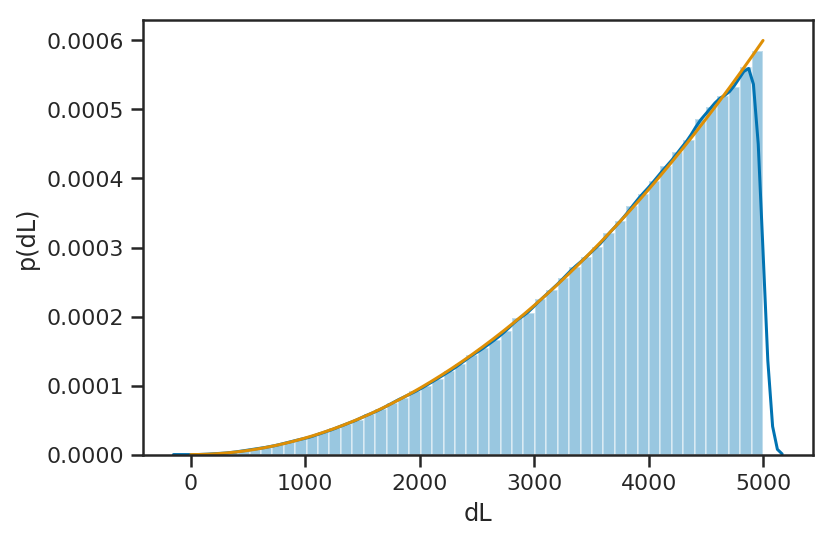

In [13]:
ax = sns.distplot(sampler.chain[:,:,2].flatten())
dLs = linspace(0, 5000, 1000)

ax.plot(dLs, 3.0*dLs*dLs/(5000*5000*5000))
ax.set_xlabel("dL")
ax.set_ylabel("p(dL)")

show()

Note that samples aren't uniform in co-moving volume

In [14]:
d = sampler.chain[:,:,2].flatten()

zi = linspace(0, 3, 1000)
di = Planck15.luminosity_distance(zi).to(u.Mpc).value
z = interp1d(di, zi)(d)

V = Planck15.comoving_volume(z).to(u.Mpc**3).value

KS = 0.1475027111080197


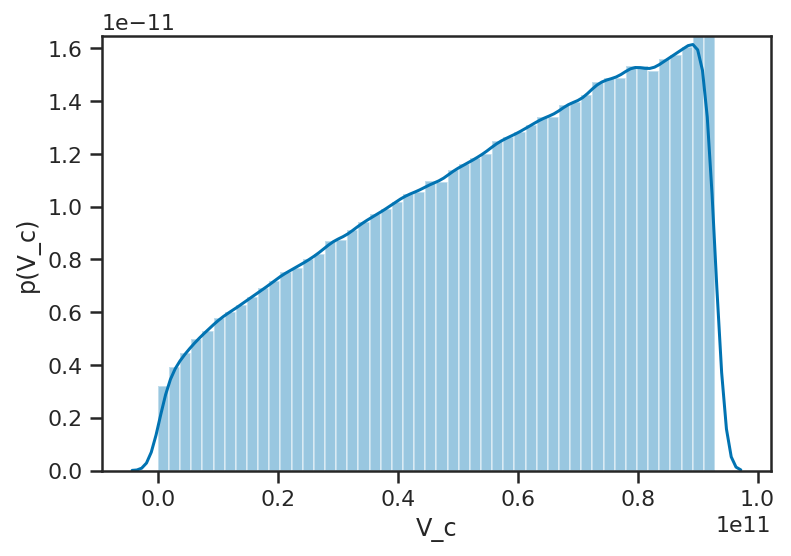

/home/daniel.wysocki/.local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


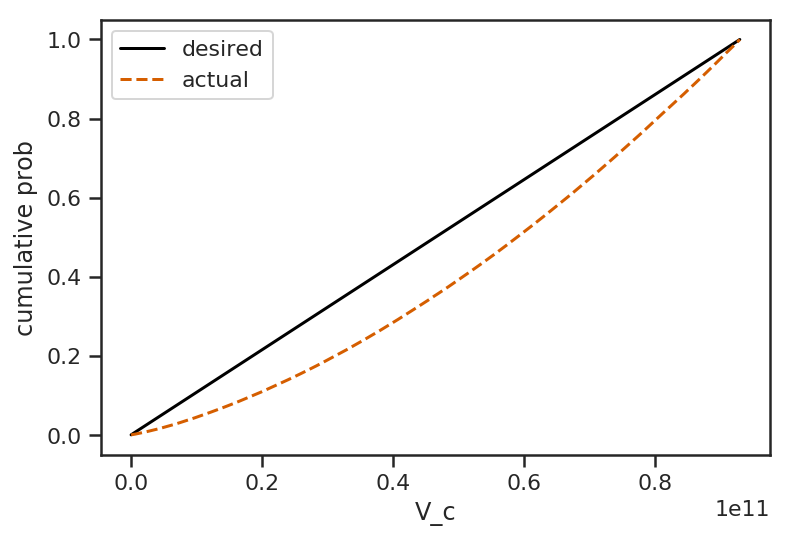

In [15]:
n_samples = V.size
V_max = V.max()
V_smooth = linspace(0.0, V_max, 1000)
cdf_uniform = V_smooth / V_max

ecdf = asarray([
    count_nonzero(V <= Vs) / n_samples
    for Vs in V_smooth
])
KS_test = np.max(np.abs(cdf_uniform - ecdf))
print("KS =", KS_test)

sns.distplot(V)
xlabel("V_c")
ylabel("p(V_c)")
show()

fig, ax = plt.subplots()
ax.plot(V_smooth, cdf_uniform, color="black", label="desired")
ax.plot(V_smooth, ecdf, color="C3", linestyle="--", label="actual")
ax.set_xlabel("V_c")
ax.set_ylabel("cumulative prob")
ax.legend(loc="upper left")
fig.show()

Now we re-weight according to the library.  This will produce samples that are flat in $m_1$-$m_2$ (source frame), and also flat in comoving volume.  

In [16]:
logwts = rewtlisamples.log_lirewt_factor(sampler.chain[:,:,2])

In [17]:
logwts = logwts - np.max(logwts) # Normalize to maxwt = 1

In [18]:
logrs = log(random.uniform(low=0, high=1, size=logwts.shape))

In [19]:
sel = logrs < logwts

In [20]:
rewt_samples = sampler.chain[sel]

Now we check that we are actually flat in $V$ and flat in $m_1$-$m_2$ (source).  We need to impose some cuts in the source frame masses, or else edge effects (detector-frame mass limits translate to distance-dependent source-frame limits) will mess us up.

In [21]:
d = rewt_samples[:,2]
zi = linspace(0, 3, 1000)
di = Planck15.luminosity_distance(zi).to(u.Mpc).value
z = interp1d(di, zi)(d)

V = Planck15.comoving_volume(z).to(u.Mpc**3).value

In [22]:
m1 = rewt_samples[:,0]/(1+z)
m2 = rewt_samples[:,1]/(1+z)

cut = (m2 > 10) & (m1 < 50)

/home/daniel.wysocki/.local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/daniel.wysocki/.local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


KS = 0.0019043601427572998


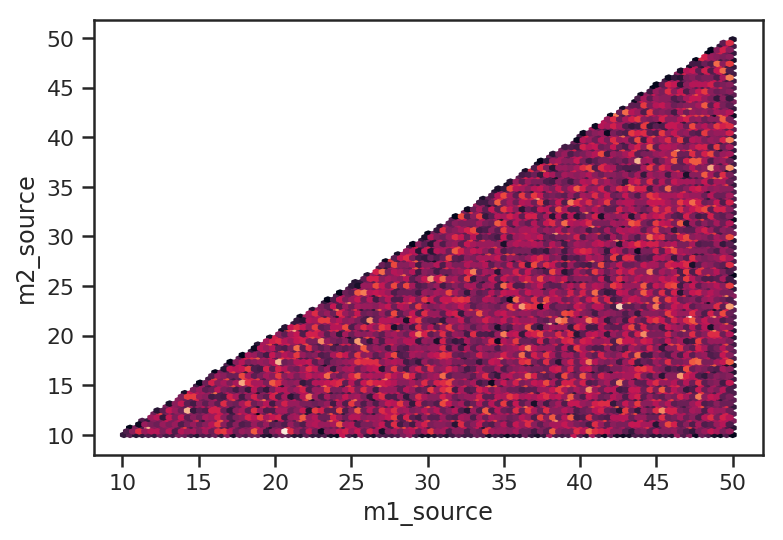

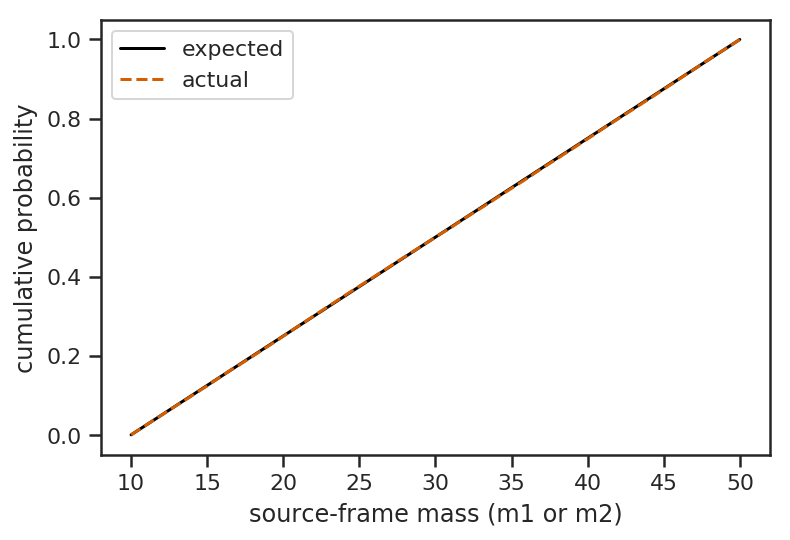

In [23]:
fig, ax = plt.subplots()
ax.hexbin(m1[cut],m2[cut],mincnt=1)
ax.set_xlabel("m1_source")
ax.set_ylabel("m2_source")
fig.show()


fig, ax = plt.subplots()

samples = numpy.concatenate((m1[cut], m2[cut]))
n_samples = len(samples)

m_range = linspace(10.0, 50.0, 1000)

cdf = (m_range-10)/(50-10)
ax.plot(m_range, cdf, color="black", label="expected")

ecdf = numpy.asarray([
    numpy.count_nonzero(samples <= m) / n_samples
    for m in m_range
])
KS_test = np.max(np.abs(cdf - ecdf))
print("KS =", KS_test)
ax.plot(m_range, ecdf, linestyle="--", color="C3", label="actual")

ax.set_xlabel("source-frame mass (m1 or m2)")
ax.set_ylabel("cumulative probability")

ax.legend()

fig.show()

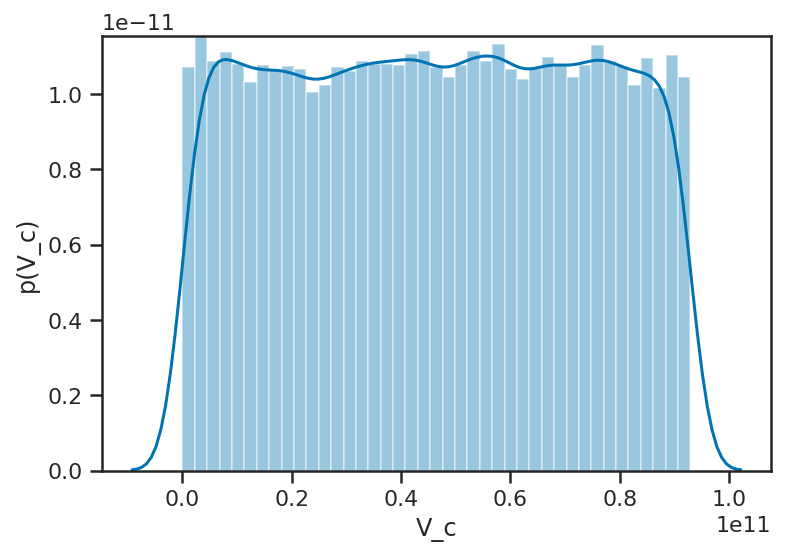

KS = 0.0030799006817447405


/home/daniel.wysocki/.local/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


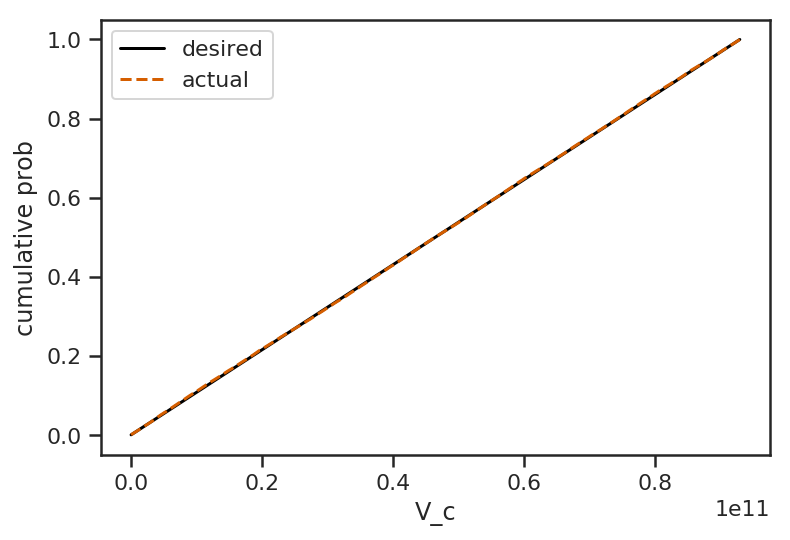

In [24]:
sns.distplot(V[cut])
xlabel("V_c")
ylabel("p(V_c)")
show()

n_samples = V[cut].size
V_max = V[cut].max()
V_smooth = linspace(0.0, V_max, 1000)
cdf_uniform = V_smooth / V_max

edf = asarray([
    count_nonzero(V[cut] <= Vs) / n_samples
    for Vs in V_smooth
])
KS = np.max(np.abs(edf - cdf))
print("KS =", KS)

fig, ax = plt.subplots()
ax.plot(V_smooth, cdf_uniform, color="black", label="desired")
ax.plot(V_smooth, edf, color="C3", linestyle="--", label="actual")
ax.set_xlabel("V_c")
ax.set_ylabel("cumulative prob")
ax.legend(loc="upper left")
fig.show()

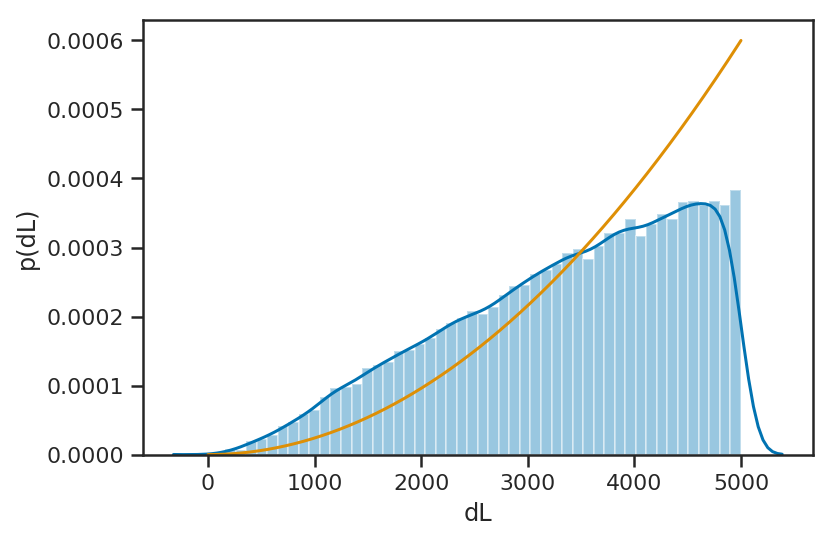

In [25]:
ax = sns.distplot(d[cut])
dLs = linspace(0, 5000, 1000)

ax.plot(dLs, 3.0*dLs*dLs/(5000*5000*5000))
ax.set_xlabel("dL")
ax.set_ylabel("p(dL)")

show()